In [111]:
import math

import pandas as pd
import seaborn as sns
from glob import glob
from datetime import datetime
import math

In [198]:
dfs = []
previous_columns = set()
for filename in sorted(glob("data/green500_top_*.xlsx")):
    print(f"\n\n# reading {filename}")
    d = datetime.strptime(filename, "data/green500_top_%Y%m.xlsx")
    df1 = pd.read_excel(filename)
    df1 = df1.rename(columns={
        "How?": "Power Source",
        "how": "Power Source",
        "proc_frequency": "Proc_Frequency",
        "operating_system": "Operating System",
        "OS": "Operating System",
        "top500_rank": "Top500_Rank",
        "green500_rank": "Green500_Rank",
        "system_family": "System Family",
        "processor_family": "Processor Technology",
        "Processor_Family": "Processor Technology",
        "Proc_Frequency": "Processor Speed (MHz)",
        "proc_frequency": "Processor Speed (MHz)",
        "Rpeak": "RPeak",
        "Power": "Power (kW)",
        "total_power": "Power (kW)",
        "mflops_per_watt": "Mflops/Watt",
        "Power Effeciency [GFlops/Watts]": "Energy Efficiency [GFlops/Watts]",
        "Power Efficiency [GFlops/Watts]": "Energy Efficiency [GFlops/Watts]",
    })
    df1 = df1.drop(columns=["Unnamed: 18",
                            "Top500_Previous_Rank", "Green500_Previous_Rank", "Rank", "First Rank", "First Appearance", "Previous Rank", "Notes", "Green500_Rank", "Top500_Rank", "TOP500 Rank",
                            "name", "Name", "Computer",
                            "Power Source.1"
                            ], errors="ignore")
    if "Mflops/Watt" in df1.columns:
        df1["Mflops/Watt"] = df1["Mflops/Watt"] / 1000
        df1 = df1.rename(columns={
            "Mflops/Watt": "Energy Efficiency [GFlops/Watts]"
        })
    if "RPeak" in df1.columns:
        df1["RPeak"] = df1["RPeak"] / 1000
        df1 = df1.rename(columns={
            "RPeak": "Rpeak [TFlop/s]"
        })
    if "Rmax" in df1.columns:
        df1["Rmax"] = df1["Rmax"] / 1000
        df1 = df1.rename(columns={
            "Rmax": "Rmax [TFlop/s]"
        })

    columns = set(df1.columns)
    assert "Mflops/Watt" not in columns
    if columns != previous_columns:
        print(f"new columns: {columns - previous_columns}")
        print(f"removed columns: {previous_columns - columns}")
        previous_columns = columns

    try:
        df1["Power Quality Level"] = df1["Power Quality Level"].where(lambda x: x != 0).dropna()
    except KeyError:
        pass
    df1["list"] = d
    # df1 = df1[sorted(df1.columns.tolist())]
    dfs.append(df1)

df = pd.concat(dfs, ignore_index=True)
df["Rmax_rounded"] = df["Rmax [TFlop/s]"].round(2)
df = df.drop_duplicates(["Rmax_rounded", "Processor Technology", "Power (kW)"], keep='first', ignore_index=True)



# reading data/green500_top_201311.xlsx
new columns: {'Processor Technology', 'Rmax [TFlop/s]', 'Region', 'Rpeak [TFlop/s]', 'System Model', 'Processor', 'Accelerator/Co-Processor', 'Interconnect Family', 'Cores per Socket', 'Interconnect', 'Site', 'Manufacturer', 'Operating System', 'Power (kW)', 'Architecture', 'System Family', 'Processor Speed (MHz)', 'Continent', 'OS Family', 'Country', 'Nmax', 'Total Cores', 'Processor Generation', 'Energy Efficiency [GFlops/Watts]', 'Year', 'Accelerator/Co-Processor Cores', 'Segment', 'Power Source'}
removed columns: set()


# reading data/green500_top_201406.xlsx
new columns: {'Nhalf'}
removed columns: set()


# reading data/green500_top_201411.xlsx


/home/tilsche/.cache/pypoetry/virtualenvs/green500-analysis-AyUEgljv-py3.11/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)




# reading data/green500_top_201506.xlsx


# reading data/green500_top_201511.xlsx


# reading data/green500_top_201606.xlsx


# reading data/green500_top_201611.xlsx


# reading data/green500_top_201706.xlsx
new columns: {'Optimized Run (HPL)', 'Measured Cores', 'Optimized Run (Peak Power)', 'Power Quality Level'}
removed columns: {'Nmax', 'Nhalf'}


# reading data/green500_top_201711.xlsx
new columns: {'System ID', 'Site ID'}
removed columns: set()


# reading data/green500_top_201806.xlsx


# reading data/green500_top_201811.xlsx


# reading data/green500_top_201906.xlsx


# reading data/green500_top_201911.xlsx


# reading data/green500_top_202006.xlsx
new columns: set()
removed columns: {'Region'}


# reading data/green500_top_202011.xlsx
new columns: set()
removed columns: {'Measured Cores'}


# reading data/green500_top_202106.xlsx
new columns: {'Memory'}
removed columns: set()


# reading data/green500_top_202111.xlsx


# reading data/green500_top_202206.xlsx


# reading data/

In [200]:
df = df.dropna(subset=["Energy Efficiency [GFlops/Watts]"])
df["ee_manual"] = df["Rmax [TFlop/s]"] / df["Power (kW)"]
df["ee_discrepancy"] = df["ee_manual"] / df["Energy Efficiency [GFlops/Watts]"]
# Soo many inconsistent numbers :{
df = df[df["ee_discrepancy"] > 0.6]
df = df[df["ee_discrepancy"] < 1.1]
df["type"] = df["Accelerator/Co-Processor"].apply(lambda x: "CPU" if isinstance(x, float) else "Accelerator")
df["Power Source"] = df["Power Source"].apply(lambda s: "Submitted" if s == "Submission" else s)
df["Measured"] = df["Power Source"].apply({
    "Submitted": True,
    "Optimized": True,
    "Derived": False,
    "Top500": False,
}.get)

/tmp/ipykernel_88535/3029019693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ee_manual"] = df["Rmax [TFlop/s]"] / df["Power (kW)"]
/tmp/ipykernel_88535/3029019693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ee_discrepancy"] = df["ee_manual"] / df["Energy Efficiency [GFlops/Watts]"]


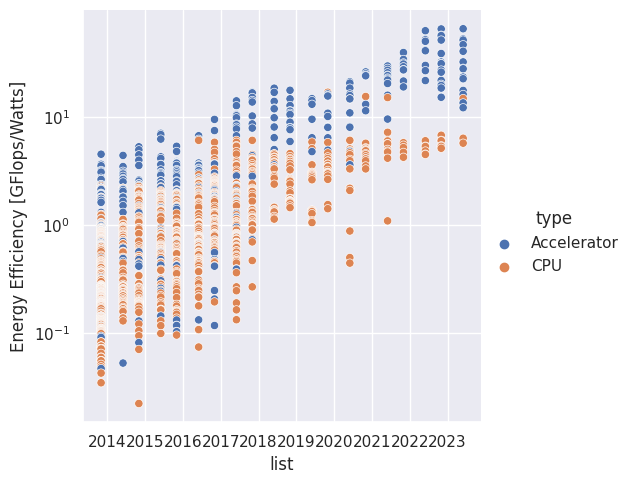

In [194]:
fg = sns.relplot(data=df, y="Energy Efficiency [GFlops/Watts]", x='list', hue="type")
# log y-scale
fg.ax.set_yscale("log")

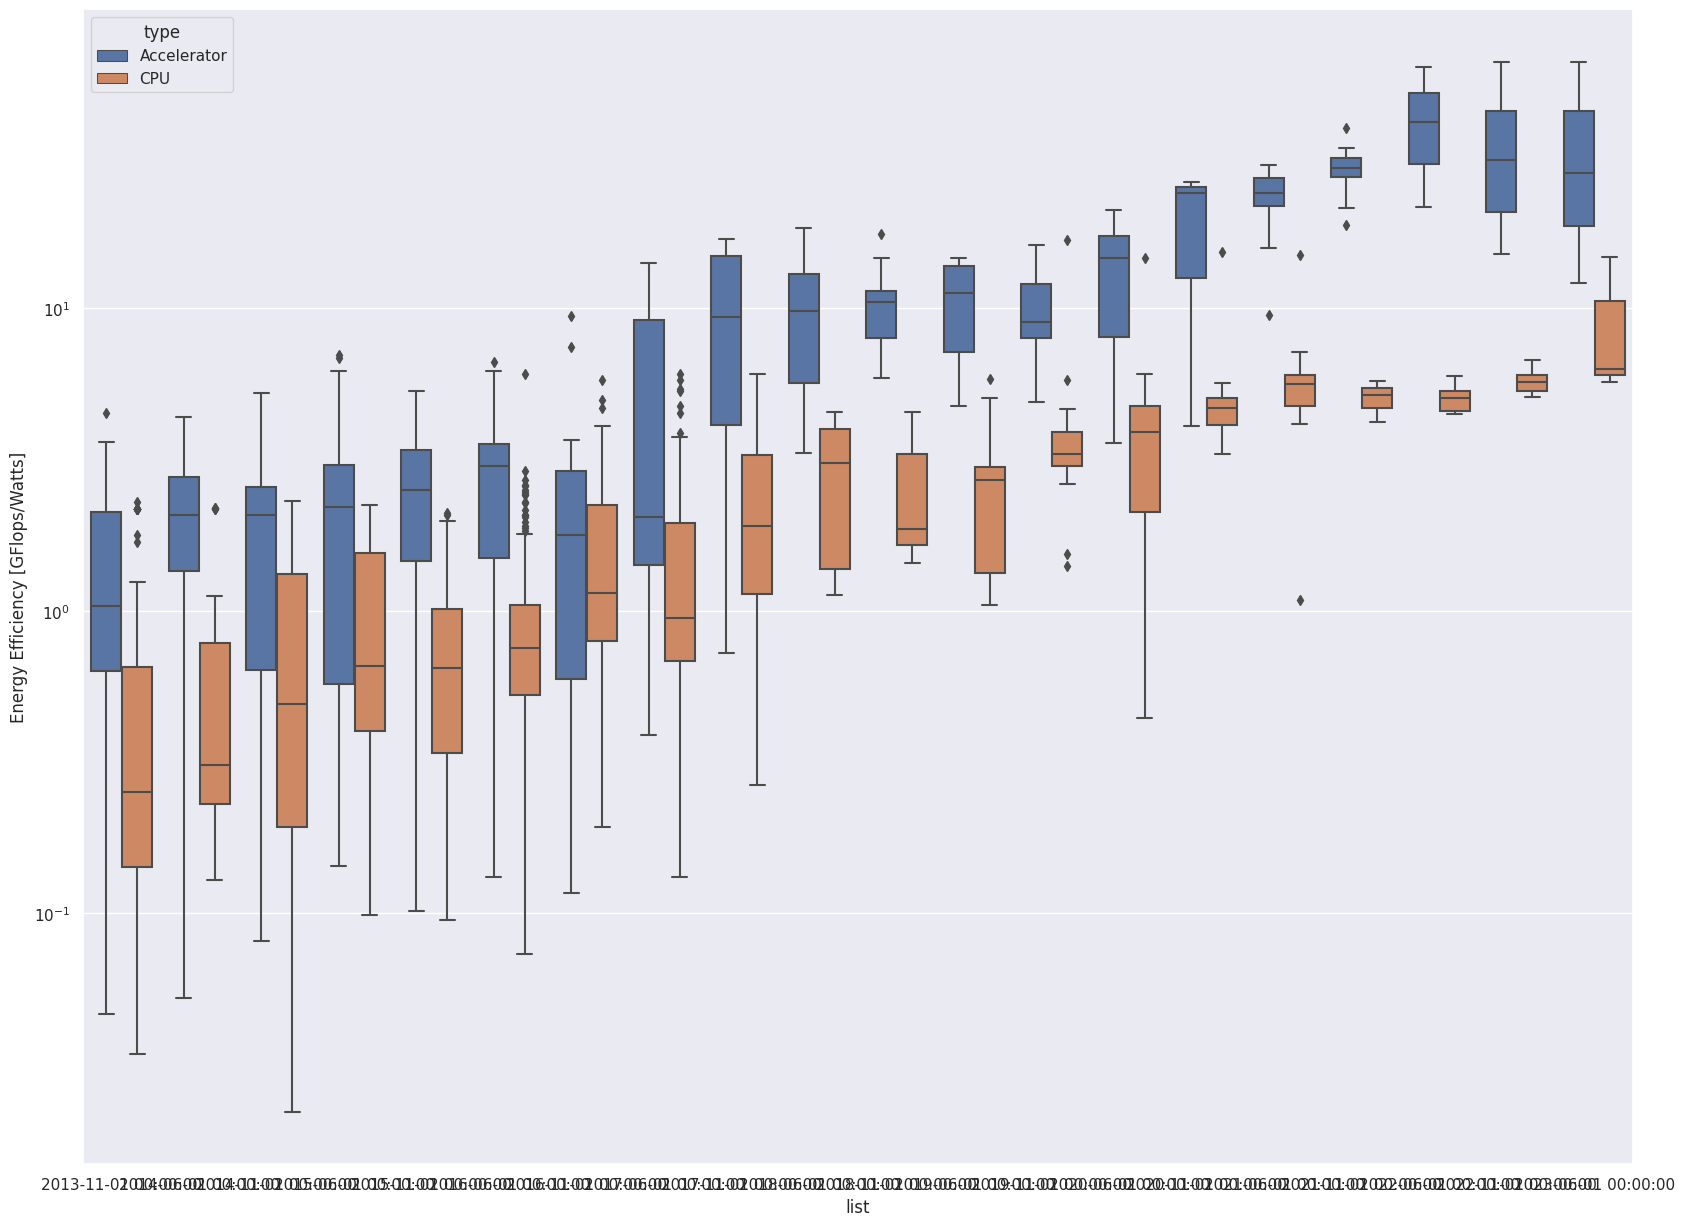

In [195]:
sns.set(rc={'figure.figsize': (20, 15)})
df["type"] = df["Accelerator/Co-Processor"].apply(lambda x: "CPU" if isinstance(x, float) else "Accelerator")
ax = sns.boxplot(data=df, y="Energy Efficiency [GFlops/Watts]", x='list', hue="type")
# log y-scale
ax.set_yscale("log")

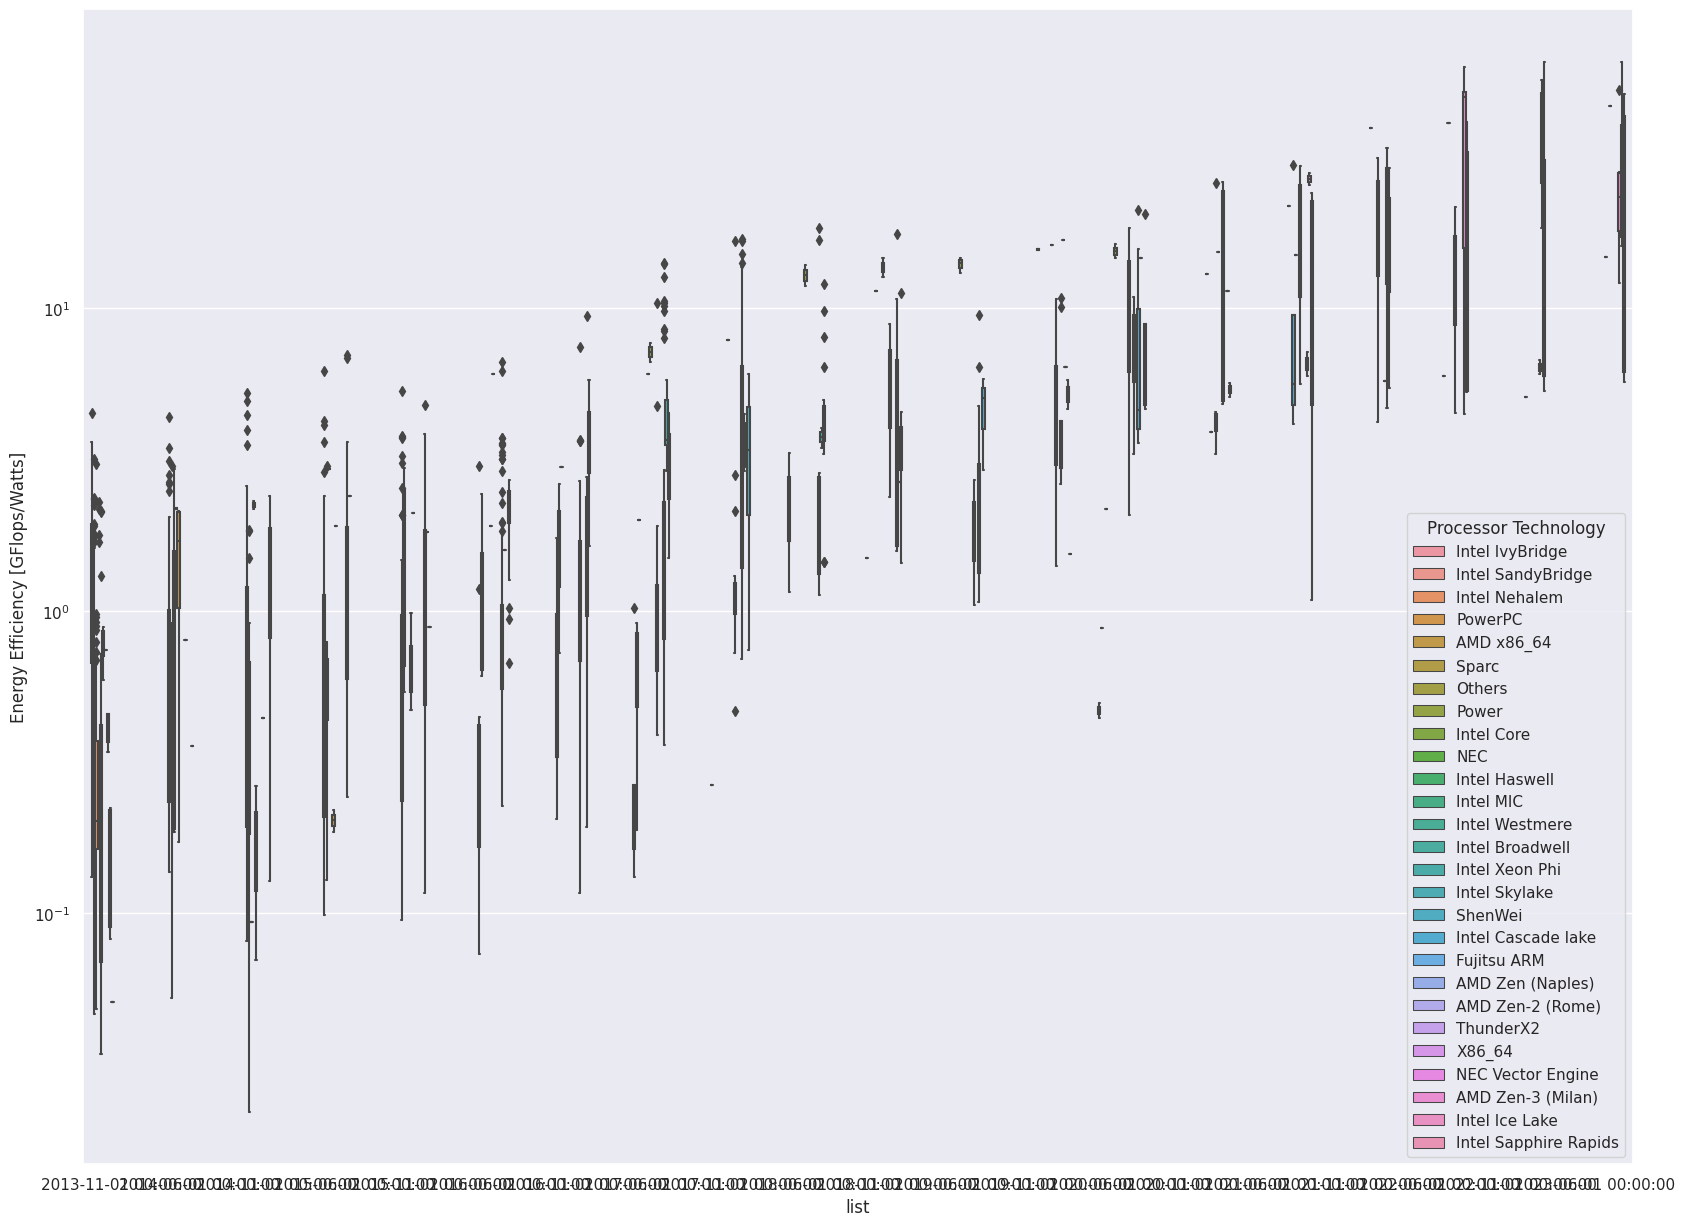

In [196]:
sns.set(rc={'figure.figsize': (20, 15)})
ax = sns.boxplot(data=df, y="Energy Efficiency [GFlops/Watts]", x='list', hue="Processor Technology")
# log y-scale
ax.set_yscale("log")

/home/tilsche/.cache/pypoetry/virtualenvs/green500-analysis-AyUEgljv-py3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 67.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tilsche/.cache/pypoetry/virtualenvs/green500-analysis-AyUEgljv-py3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 32.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tilsche/.cache/pypoetry/virtualenvs/green500-analysis-AyUEgljv-py3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/tilsche/.cache/pypoetry/virtualenvs/green500-analysis-AyUEgljv-py3.11/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarn

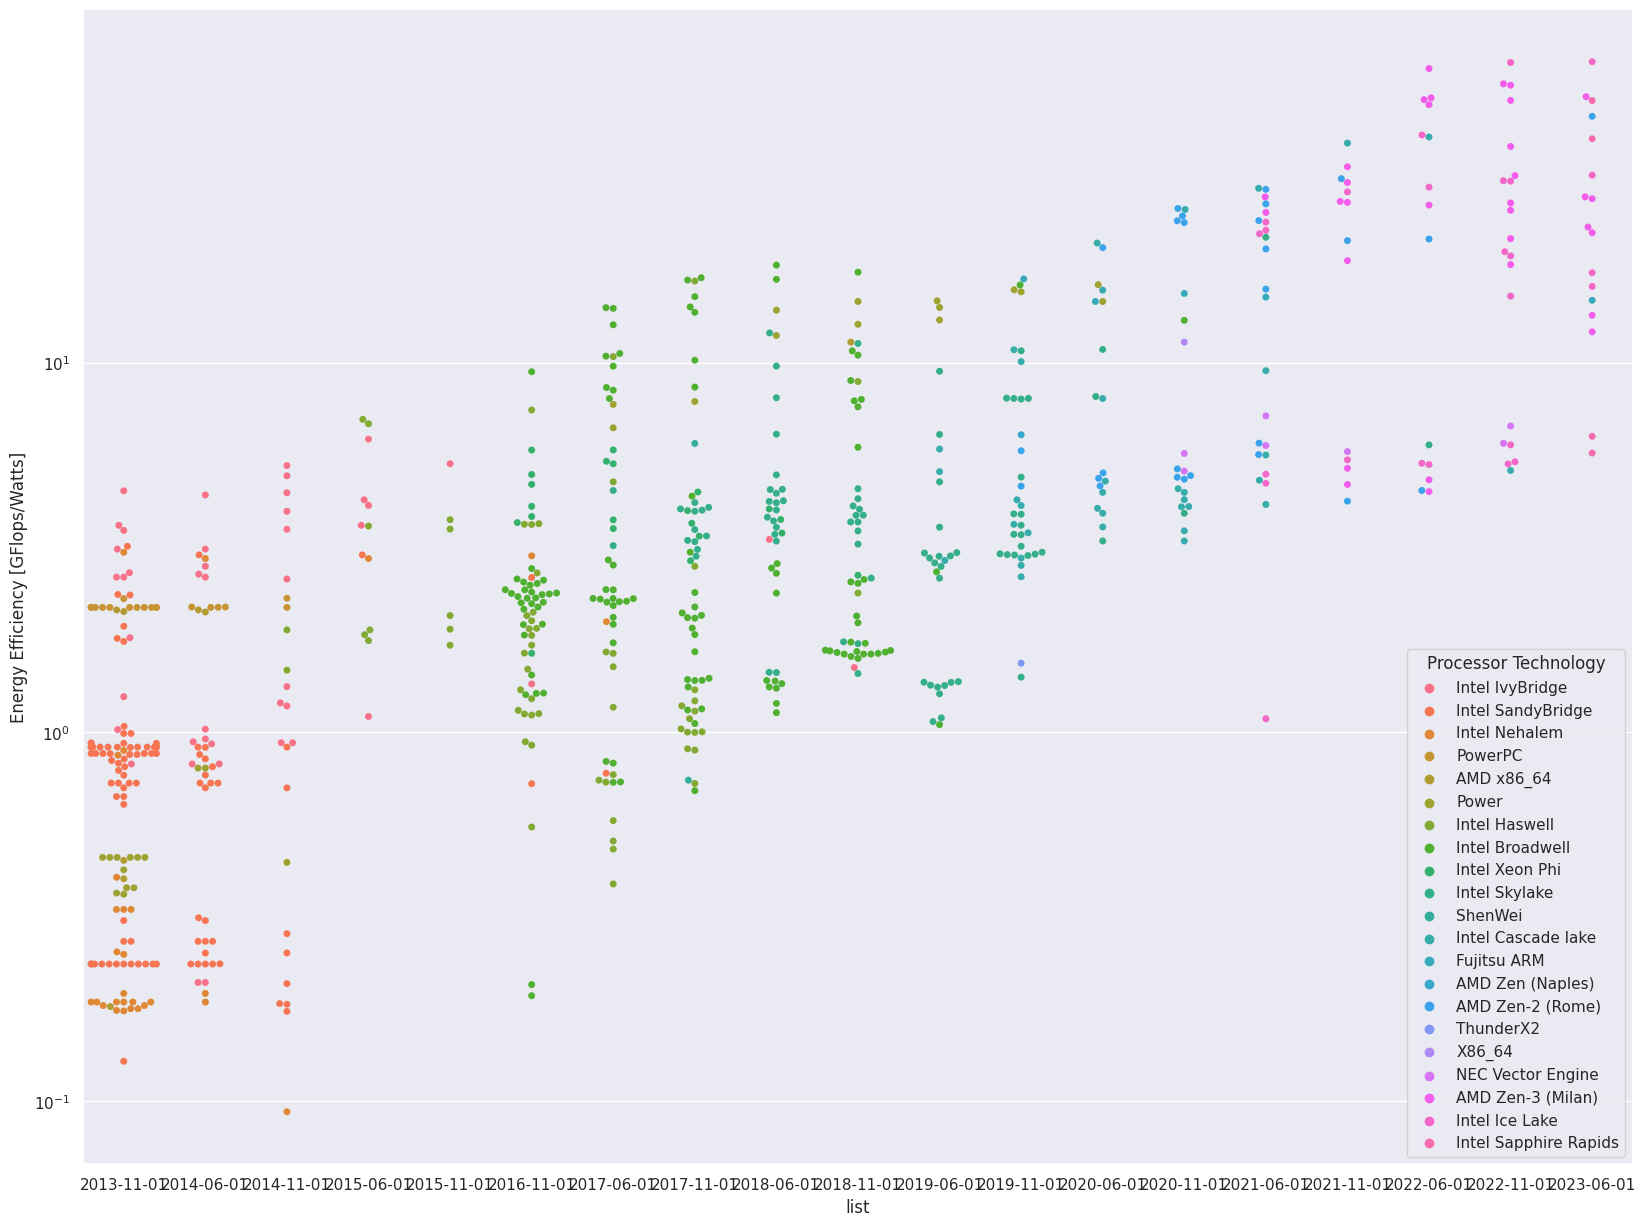

In [201]:
sns.set(rc={'figure.figsize': (20, 15)})
dff = df[df["Measured"] == True]
ax = sns.swarmplot(data=dff, y="Energy Efficiency [GFlops/Watts]", x='list', hue="Processor Technology")
# log y-scale
ax.set_yscale("log")

In [185]:
debug = {}
for list, dfl in df.groupby("list"):
    debug[list] = dfl
    mc = len(dfl[dfl["Measured"] == True])
    print(f"# {list} - {mc} of {len(dfl)}")
    # print(dfl["Power Source"].value_counts())
    # print(dfl["Power Quality Level"].value_counts())
    # print(dfl["Measured"].value_counts())
    print(dfl["Processor Technology"].value_counts())

# 2013-11-01 00:00:00 - 126 of 426
Processor Technology
Intel SandyBridge    256
Intel Nehalem         60
AMD x86_64            42
Intel IvyBridge       30
PowerPC               14
Power                 14
Intel Core             5
Sparc                  3
Others                 1
NEC                    1
Name: count, dtype: int64
# 2014-06-01 00:00:00 - 46 of 113
Processor Technology
Intel IvyBridge      60
Intel SandyBridge    39
PowerPC               4
AMD x86_64            4
Intel Nehalem         3
Power                 2
Intel Haswell         1
Name: count, dtype: int64
# 2014-11-01 00:00:00 - 25 of 111
Processor Technology
Intel IvyBridge      61
Intel Haswell        26
Intel SandyBridge    18
PowerPC               2
AMD x86_64            2
Power                 1
Intel Nehalem         1
Name: count, dtype: int64
# 2015-06-01 00:00:00 - 13 of 123
Processor Technology
Intel Haswell        57
Intel IvyBridge      48
Intel SandyBridge    11
Sparc                 3
AMD x86_64         